In [1]:
from importlib.metadata import version


print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.7.0
tiktoken version: 0.7.0


### coding an LLM architecture - GPT
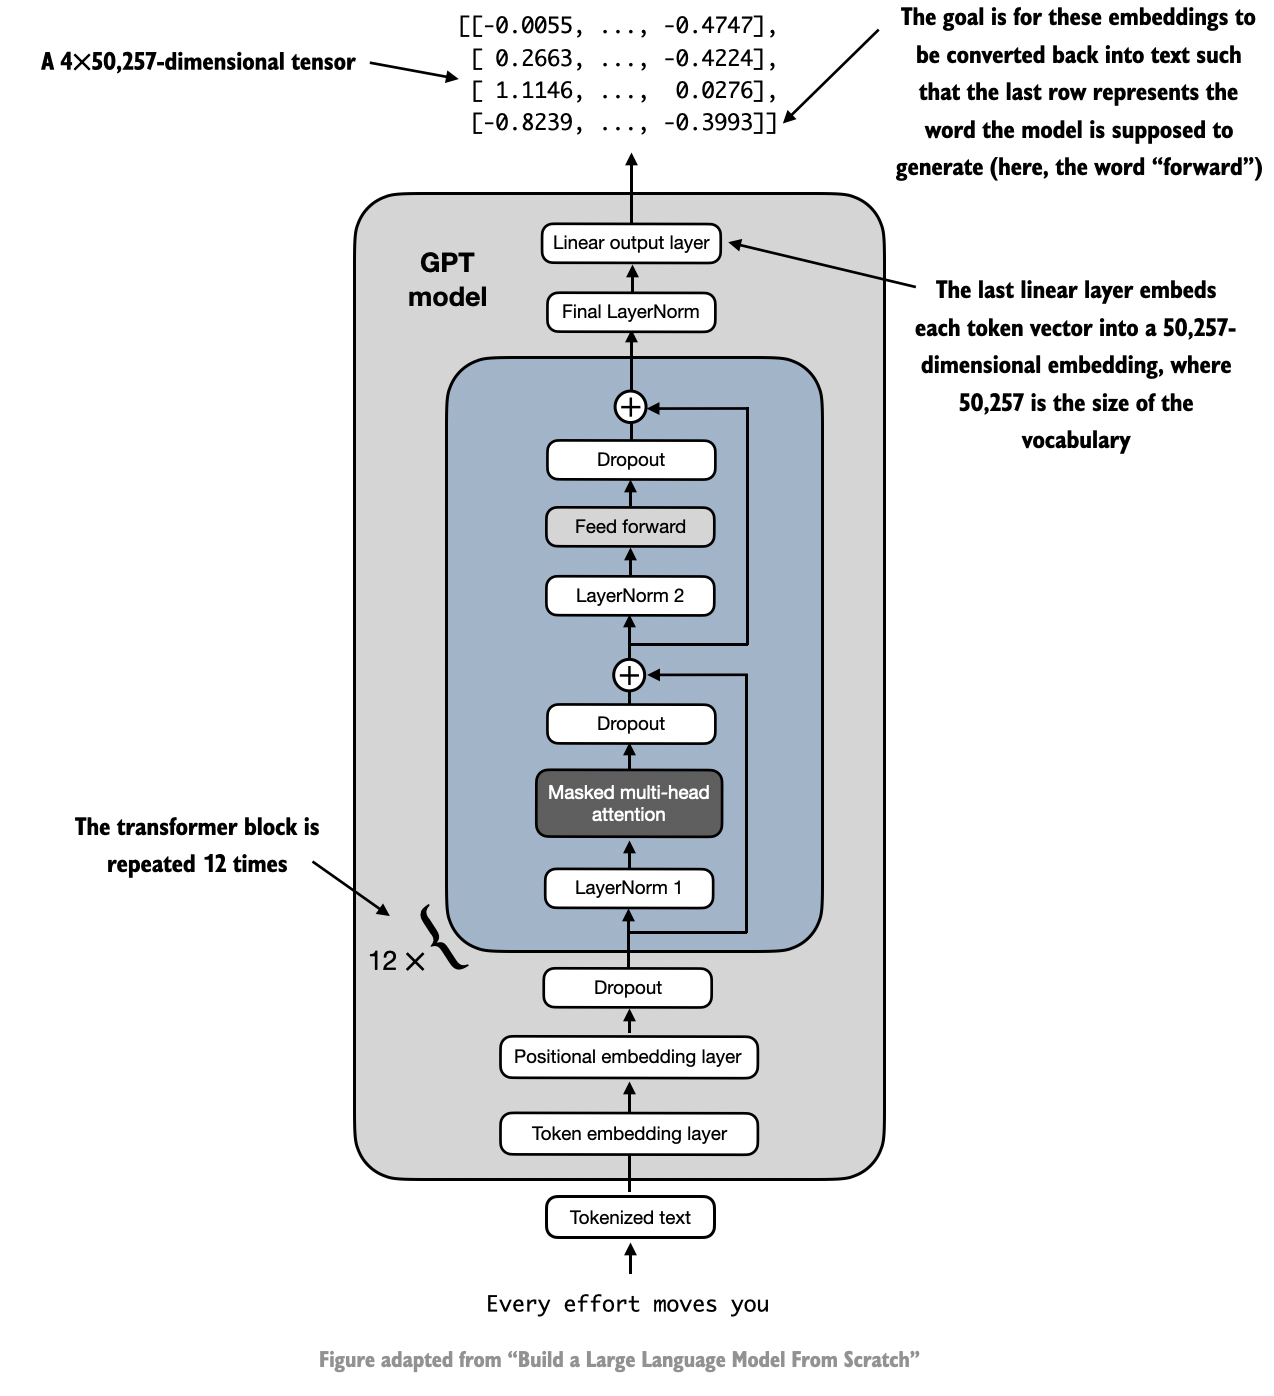

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [3]:
import torch
import torch.nn as nn
from utils import TransformerBlock, LayerNorm


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [4]:
import torch
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [6]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 6.4164e-02,  2.0443e-01, -1.6945e-01,  ...,  1.7887e-01,
           2.1921e-01, -5.8153e-01],
         [ 3.7736e-01, -4.2545e-01, -6.5874e-01,  ..., -2.5050e-01,
           4.6553e-01, -2.5760e-01],
         [ 8.8996e-01, -1.3770e-01,  1.4748e-01,  ...,  1.7770e-01,
          -1.2015e-01, -1.8902e-01],
         [-9.7276e-01,  9.7338e-02, -2.5419e-01,  ...,  1.1035e+00,
           3.7639e-01, -5.9006e-01]],

        [[ 6.4164e-02,  2.0443e-01, -1.6945e-01,  ...,  1.7887e-01,
           2.1921e-01, -5.8153e-01],
         [ 1.3433e-01, -2.1289e-01, -2.7021e-02,  ...,  8.1153e-01,
          -4.7410e-02,  3.1186e-01],
         [ 8.9996e-01,  9.5396e-01, -1.7896e-01,  ...,  8.3053e-01,
           2.7657e-01, -2.4577e-02],
         [-9.2814e-05,  1.9390e-01,  5.1217e-01,  ...,  1.1915e+00,
          -1.6431e-01,  3.7046e-02]]], grad_fn=<UnsafeViewBackward0>)


### generating text

In [7]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [8]:
model.eval();  # disable dropout

In [9]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [10]:
out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [12]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)  ## untrained model - garbage output

Hello, I am Featureiman Byeswickattribute argue
